# Lecture notes

In this file you will find notes and scripts related to *[Mathematical Analysis of PWM Processes][def]* by Gregory R. Ainslie-Malik from The University of Nottingham

[def]: https://eprints.nottingham.ac.uk/13021/1/Mathematical_Analysis_of_PWM_Processes.pdf

# Introduction
## 1 Inverter design
* All inverter are supplied by an upper DC source of a prescribed voltage, and a lower DC source of a prescribed voltage.
* Three-phase inverters are commonly used for variable-frequency drive applications, which control the speed of an AC motor by adjusting the frequency of the electrical power supply.

## 1.2 PWM Methods
* PWM is a  high-frequency modulation strategy, made feasible by transistor, which can operate at the required high frequencies.
* PWM generates a square wave that switches between two values at a high frequencies, modulating the width of the pulses

![PWM parts][pwm parts]
![Sinusoidal PWM: (a) triangular carrier wave and sinusoidal reference signal, (b) gate pulse signal][pwm parts2]

* The square wave is constructed to have low-frequency components that provide a good approximation to the signal wave. In order to achieve this, the switch times of the square wave are determined by samples of the signal wave.
* There are two common sampling methods, known as *uniform* (or *regular*) and *natural* sampling. PWM inverters use both uniform and natural sampling.
    * Samples of the signal wave are taken at fixed intervals when using uniform sampling

![Uniform sampling and Natural sampling comparison][uniform and natural sampling comparison]

* PWM square waves generated with natural sampling do not have any low-frequency distortion.
* Space vector modulation (SVM) is limited to inverters with three or more phase lages, and is shown to be advantegous because **SVM inverters generate lower current harmonics** compared to standard PWM inverters.
* Both natural and uniform sampling are used in SVM inverters, but because SVM is better suited to digital devices, uniform sampling is more common

[pwm parts]: media/pwm%20parts.jpg
[pwm parts2]: media/Sinusoidal-PWM-a-triangular-carrier-wave-and-sinusoidal-reference-signal-b-gate.png
[uniform and natural sampling comparison]: media/uniform%20and%20natural%20sampling.PNG

## 1.3 Identification of High-Frequency Components Generated by PWM Inverters
* High-frequency components are also generated in the inputs and outputs of inverters by the load impedance
### 1.3.1 Calculations of Output Voltages and Currents
The Poisson re-summation method involves writing the voltage output as a discrete switching function in the time domain, then taking a Fourier transform. Use of the Poisson re-summation formula then allows us to identify a Fourier series expression for the voltage output

# 2 Voltage Spectra for PWM Inverters

## 2.1 Introduction
Frequency spectra of the output voltages are used to quantify the deviation of the low-frequency components from the intended signal wave, and to identify the high-frequency components, which will ultimately be filtered out.

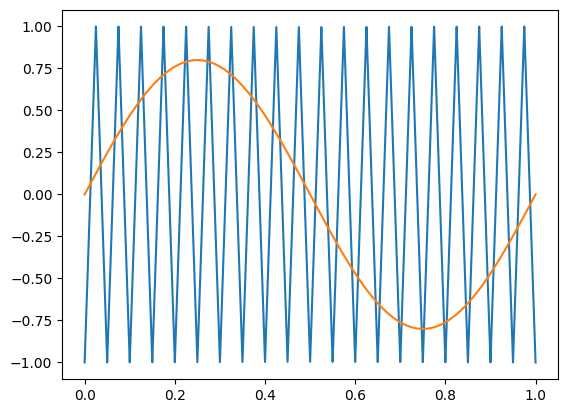

In [2]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt 

pi = np.pi
simulation_time = 1
time_step = 1e-4
ticks = int(simulation_time/time_step)

simulation_time = time_step * ticks
t = np.linspace(0,simulation_time,ticks)
ws = 1
wc = 20*ws
m = 0.8
triangle = signal.sawtooth(2*pi * wc *t ,0.5)
sine = m*np.sin(2*pi*ws*t)

plt.plot(t,triangle,t,sine)

## 2.2 Single-phase Inverter
Using PWM, high-frequency modulation of the swithces generates a voltage ouput, $v_{a}(t)$
Defining the signal $s_{a}\left(t\right)=M\cos{\left(\omega_{s} t\right)}$
Where $|M|<1$ is the modulation index, or (constant) amplitude, and $\omega_{s}$ is the frequency. In order to determine the switch times of $v_{a}(t)$, the signal wave is then sampled according to uniform sampling, or natural sampling. See more about sampling in [PWM Generator (Three-phase, Three-level)][mathworks documentation]

[mathworks documentation]:https://www.mathworks.com/help/sps/ref/pwmgeneratorthreephasethreelevel.html

In [3]:
from abc import abstractmethod


class Signal:
    def __init__(self,amplitude,frequency):
        self.amplitude = amplitude
        self.frequency = frequency
        self.period = 1/frequency
        self.fun  = lambda x : x
    
    def output(self, t):
        self.t = t
        self.out = self.fun(t)
        return self.out

class SineSignal(Signal):
    
    def __init__(self,amplitude,frequency):
        Signal.__init__(self,amplitude,frequency)
        self.fun = lambda t : self.amplitude * np.sin(self.frequency * t)
    
class CarrierSignal(SineSignal):

    def __init__(self,frequency, amplitude=1, width =0.5):
        Signal.__init__(self,amplitude,frequency)
        self.width = 0.5
        self.fun = lambda t: self.amplitude*signal.sawtooth(self.frequency*t ,self.width)
        

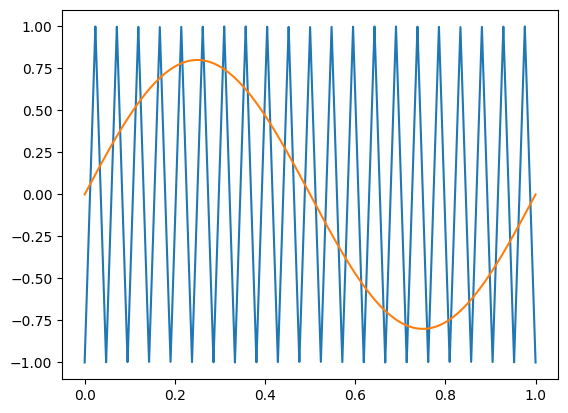

In [4]:
pi = np.pi


fs = 1
period = 1/fs

ws = 1
wc = 21*ws
m = 0.8

time_step = int(period*10000)

t = np.linspace(0,period,time_step)
carrier = CarrierSignal(2*pi*wc)
sine = SineSignal(m,ws*2*pi)
plt.plot(t,carrier.output(t),t,sine.output(t))

In this paper they use the following model to simulate the carrier signa. It is important to mention that this portion of the code will only be used to explain, but for the rest of the work I'll be using the carrier function showed above.

$$
w\left(t\right) =
    \begin{cases} 
        -1 +\frac{4(t−mT)}{T},& \text{for } mT < t < (m +\frac{1}{2})T, \\
        3 -\frac{4(t−mT)}{T} &  \text{for } (m +\frac{1}{2})T < t < (m +1)T
    \end{cases}
$$

Where $m$ is any integer and $T = 2π/ω_c$ is the switching period (and $ω_c > ω_s$ is the switching
frequency)

Carrier frequency 6.283185307179586, carrier period 0.007578806813899778, manual period 0.047619047619047616


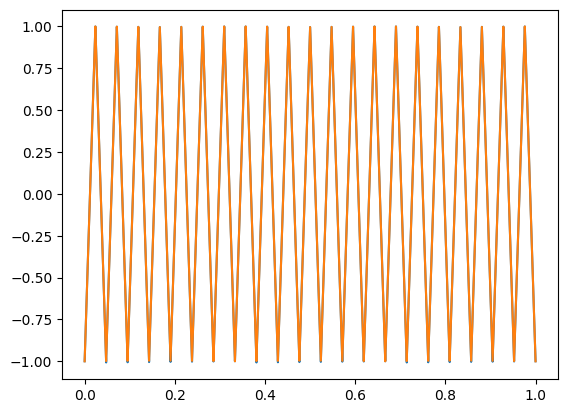

In [5]:
def calculate_manual_carrier(period,t):
    a = 1
    m_carrier = [lambda ti: -1+4*(ti-m*period)/period, lambda ti: 3-  4*(ti-m*period)/period]
    out = []
    m = 0
    for i in t:
        eval = m_carrier[1]
        if i >= m*period and i<(m+1/2)*period:
            eval = m_carrier[0]
        out.append(eval(i))
        if i>(m+1)*period:
            m += 1
    return out

carrier_period = 1/wc
manual_carrier=calculate_manual_carrier(carrier_period,t)
carrier_t = 1/carrier.frequency
print('''Carrier frequency {}, carrier period {}, manual period {}'''.format(sine.frequency,carrier_t,carrier_period))
plt.plot(t,manual_carrier,t,carrier.output(t))

In the graph above you can appreciate how the manual signal and the one provided by the library are equivalent

Text(0.5, 1.0, 'Natural sampling')

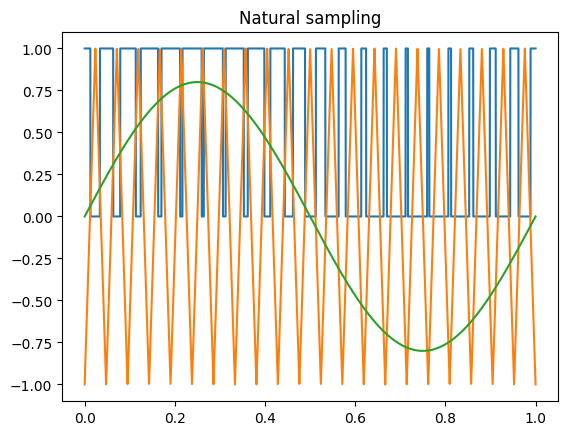

In [6]:
# Sampling comparison
def natural_sampling(carrier_signal, modulated_signal):
    output = []
    for i,y in enumerate(modulated_signal.out):
        state = 1
        if(carrier_signal.out[i]>y): state =0
        output.append(state)
    return output
natural = natural_sampling(carrier,sine)

plt.plot(t,natural,t,carrier.out,t,sine.out)
plt.title("Natural sampling")

Text(0.5, 1.0, 'Uniform symmetrical sampling')

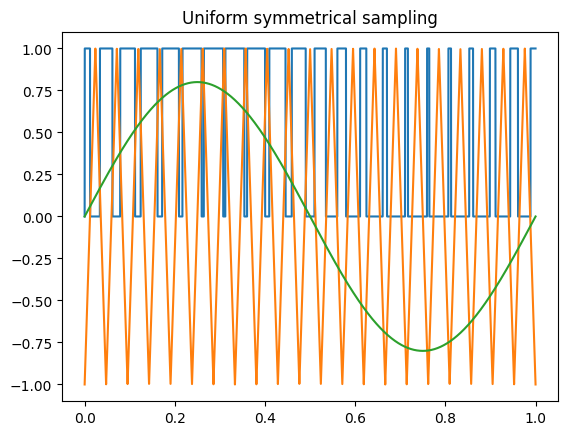

In [7]:
# Uniform sampling symmetrical
def symmetrical_sampling(carrier_signal:Signal, modulated_signal:Signal):
    output = []
    old_value = 0
    old_delta = 0
    delta = 0
    hold = 0
    output.append(0)
    sampled = [0]
    read = False
    for i,y in enumerate(carrier_signal.out):
        delta = y - old_value
        
        if old_delta == 0: 
            old_delta = delta
            continue
        if(delta * old_delta < 0 ):
            if y > 0:
                read = True
        if read:
            ym = modulated_signal.out[i]
            if old_value > ym and ym>y:
                 hold = modulated_signal.out[i]
                 read = False
        state = 1
        if(hold<y): state =0

        old_delta = delta
        old_value = y
        sampled.append(hold)
        output.append(state)
    return output, sampled

symmetrical,s_sampled = symmetrical_sampling(carrier,sine)

plt.plot(t,symmetrical,t,carrier.out,t,sine.out)
plt.title("Uniform symmetrical sampling")


Text(0.5, 1.0, 'Uniform symmetrical sampling')

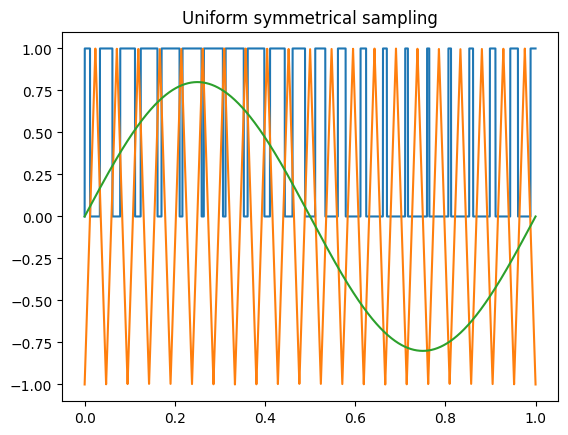

In [8]:
# Uniform sampling symmetrical
def asymmetrical_sampling(carrier_signal:Signal, modulated_signal:Signal):
    output = []
    old_value = 0
    old_delta = 0
    delta = 0
    hold = 0
    output.append(0)
    sampled = [0]
    read = False
    for i,y in enumerate(carrier_signal.out):
        delta = y - old_value
        
        if old_delta == 0: 
            old_delta = delta
            continue
        if(delta * old_delta < 0 ): read = True
        if read:
            ym = modulated_signal.out[i]
            if old_value > ym and ym>y or ym>old_value and ym<y:
                 hold = modulated_signal.out[i]
                 read = False
        state = 1
        if(hold<y): state =0

        old_delta = delta
        old_value = y
        sampled.append(hold)
        output.append(state)
    return output, sampled

asymmetrical,a_sampled = asymmetrical_sampling(carrier,sine)

plt.plot(t,asymmetrical,t,carrier.out,t,sine.out)
plt.title("Uniform symmetrical sampling")

Text(0.5, 1.0, 'Comparison of sampled signals')

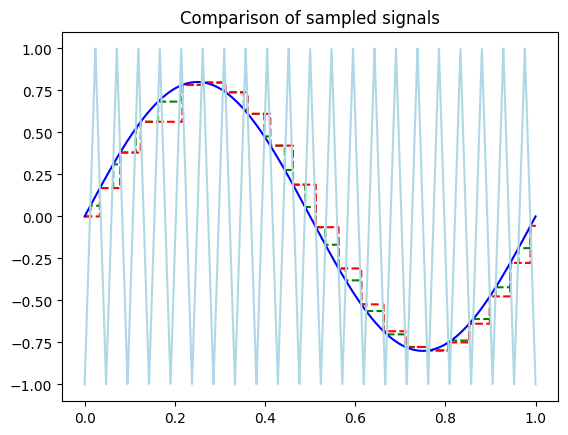

In [9]:
plt.plot(t,a_sampled,"g--",t,s_sampled,"r--",t,sine.out,"b",t,carrier.out,"lightblue")
plt.title("Comparison of sampled signals")

Text(0.5, 1.0, 'Comparison of PWM signal generation by different uniform sampling methods')

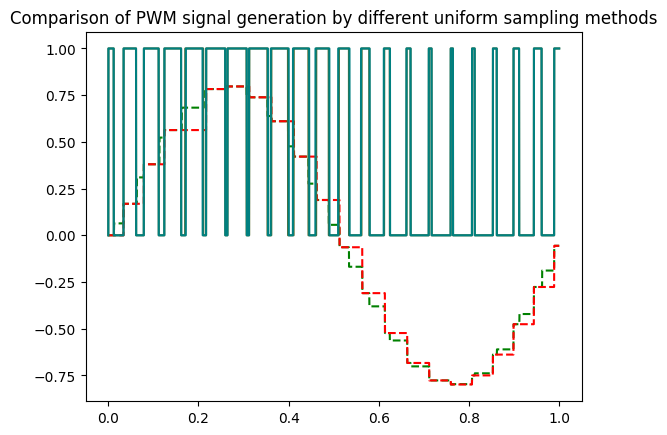

In [10]:
plt.plot(t,a_sampled,"g--",t,s_sampled,"r--",t,asymmetrical,"darkolivegreen",t,symmetrical,"teal")
plt.title("Comparison of PWM signal generation by different uniform sampling methods")

![](media/Single%20PWM.PNG)

### 1.2.3 Sinusoidal PWM
* SPWM provides good performance of the drive in entire  range of operation between 0 and 78% of the value that would be reached by square
* If the modulation index exceeds this value, the linear relationship between the modulation index and the output voltage is not maintained, and over-modulation methods are required
* In this modulation method, the ON and OFF instances of the PWM signals can be determined by comparing a reference signal with a high-frequency triangular wave.
* The frequency of the output voltage can be determined by the frequency of the modulation wave.
* The peak amplitude of the modulating wave determines the modulation index and  in turn controls the RMS value of the output voltage. When the modulation index is  changed, the RMS value of the output voltage also changes. This technique improves the distortion factor significantly compared to other ways of multiphase modulation. 
* It eliminates all harmonics less than or equal to (2n − 1). $\text{Where } n \text{ is defined as the number of pulses per half cycle of the sine wave.}$
* The output voltage of the inverter contains harmonics. However, the harmonics are pushed to the range around the carrier frequency and its multiples

$\text{Amplitude modulation ratio: }m_a=\frac{\text{peak amplitude of }V_{control}}{\text{amplitude of } V_{carrier}}=\frac{\text{Peak value of }(V_{A0})_1}{V_{dc}/2}$

Where: $(V_{A0})_1$ is the fundamental frequency component of the pole voltage V_{A0}

$m_f$ is the frequency modulation ratio, *which should be an odd integer* $ m_f = \frac{\text{PWM frequency}}{\text{fundamental frequency}}$
* If $m_f$ is not an integer, subharmonics may exist at output voltage.
* If $m_f$ is not odd, dc component may exist and even harmonics are present at output voltage.
* $m_f$ should be a multiple of 3 for three-phase PWM inverter.
* An odd multiple of three and even harmonics are suppressed.

### 1.3.6 Space Vector PWM
In the space vector PWM (SVPWM) method, the output voltage is approximated using the nearest three output vectors that the nodes of the triangle containing the reference vector in the space vector diagram of the inverter. When the reference vector changes from one region to another, it may induce an abrupt change in the output vector. In addition we need to calculate the switching sequences and switching time of the states at every change of the reference voltage location.

## 1.4 Advantages of pulse width modulation techniques
* Using PWM techniques, lower-order harmonics can be eliminated or minimized along with its output voltage control. The filtering requirements are also minimized.
* Both output voltage control and frequency control are possible in a single power stage of the inverter without any additional components.
* The presence of constant dc supply permits the parallel operation of several independent PWM inverters on the same rectifier power supply. The PWM inverter has a transient response that is much better than that of a quasi-square wave rectifier.
* The commutative ability of PWM inverters remains substantially constant compared to variable dc-link inverter, irrespective of the voltage and frequency settings
* The power factor of the system is good, as a diode rectifier can be employed on the line side.
* With constant dc supply used in PWM, we can obtain commutation even at low voltage, whereas a six-step inverter needs an auxiliary dc supply for commutating thyristors at low output voltages.
* The amplitude of the torque pulsations are minimized even at low speeds.
* A sophisticated PWM technique eliminates lower-order harmonics in the motor current, low-speed torque pulsations, and cogging effects